# Real-time American Sign Language Interpretation using Deep Convolutional Neural Networks

In spite of being the 4th most commonly used language in the United States, sign language is actively used by only 10-14% of the members of the speech and hearing impairment community and persists to be one of the most understudied areas. In compliance with recent progress in deep learning technologies, our project explores the possibility of using deep convolutional neural networks (dCNNs) in interpreting American Sign Language in real-time. This porject aims to develop a dCNN from scratch and train it using a dataset patterned to closely match the format of the classic MNIST dataset (28x28 pixel images with pixel values ranging from 0- 255). The evaluation of the network shows that it outperforms all previous implementations surrounding this task with 98.7% accuracy on the test set. To make the solution as accessible as possible, we refrained from using sophisticated hardware like motion tracking gloves and depth-sensing cameras and deployed the trained model as a multiplatform mobile application. 

###Importing the necessary libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
!pip install keras_sequential_ascii

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Downloading and extracting Kaggle dataset

In [3]:
os.environ['KAGGLE_USERNAME'] = "arghyabiswas0" #username from Kaggle json file
os.environ['KAGGLE_KEY'] = "8141469f79b01a1c6c028a37e25912c1" #key from Kaggle json file
!kaggle datasets download -d datamunge/sign-language-mnist #dataset api copied from Kaggle
from zipfile import ZipFile
file_name = "sign-language-mnist.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

 78% 49.0M/62.6M [00:01<00:00, 29.9MB/s]
100% 62.6M/62.6M [00:01<00:00, 51.8MB/s]
Done


###Load train and test datasets

In [21]:
train_df = pd.read_csv('sign_mnist_train.csv') #load train dataset
test_df = pd.read_csv('sign_mnist_test.csv') #load test dataset
y = test_df['label'] #make a copy of the test dataset labels for model evaluation later
train_df.shape
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


###Data visualization and preprocessing

Let us take a look at the number of training examples for each class. 

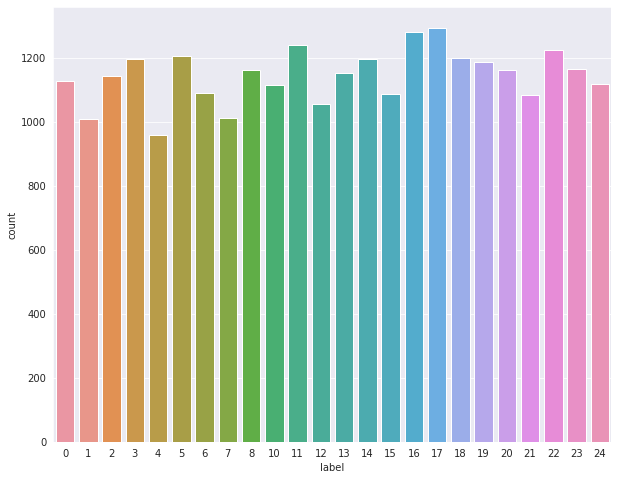

In [22]:
plt.figure(figsize = (10,8))
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

The dataset seems fairly balanced as has enough training examples for each class (900+) and also there is no significant difference in the number of training examples for each.

In [23]:
y_train = train_df['label'] #store train dataset labels in a seperate list
y_test = test_df['label'] #store train dataset labels in a seperate list
del train_df['label'] #delete labels column from train dataset
del test_df['label']  #delete labels column from test dataset

###Binarizing the labels

In [24]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train) #binarize train labels
y_test = label_binarizer.fit_transform(y_test) #binarize test labels

In [25]:
x_train = train_df.values #input matrix from training dataset
x_test = test_df.values #input matrix from test dataset

###Performing grayscale normalization

Each pixel value is an integer ranging from 0 to 255. This range is too high and makes the network converge slower. So, the best approach is to normalize the data. In our case, as the pixel value is in the known range it was sufficient to conduct min-max normalization, i.e., to scale the pixel values in the range of [0,1] by simply dividing the array by 255.

In [26]:
x_train = x_train/255 #perform grayscale normailization on training dataset
x_test = x_test/255 #perform grayscale normailization on test dataset

In [27]:
x_train = x_train.reshape(-1,28,28,1) #reshape training data for CNN input
x_test = x_test.reshape(-1,28,28,1) #reshape test data for CNN input

###Previewing few images from the training dataset

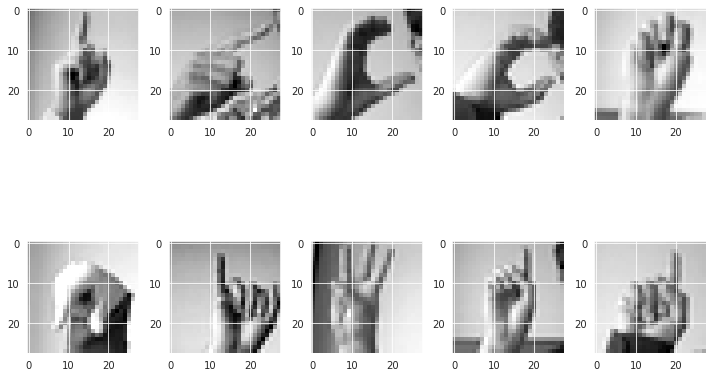

In [28]:
f,ax = plt.subplots(2,5) 
f.set_size_inches(10,10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28),cmap = "gray")
        k += 1
    plt.tight_layout()

###Perform data augmentation

Deep neural networks are usually very data-hungry affairs and lack mechanisms to learn abstractions from a limited amount of data. Data augmentation is a strategy that enables us to considerably improve the diversity of the available data for training models by applying small transformations, without actually collecting new data. For our implementation, we opt to randomly rotate an image by 10°, randomly zoom by 10%, randomly shift images horizontally by 10% of the total width and randomly shift images vertically by 10% of the total height.

In [29]:
datagen = ImageDataGenerator(
        rotation_range=10, #randomly rotate images in the 10degrees range
        zoom_range = 0.1, #randomly zoom images by 10%
        width_shift_range=0.1, #randomly shift images horizontally by 10%
        height_shift_range=0.1, #randomly shift images vertically by 10%
        horizontal_flip=False, #randomly flip images
        vertical_flip=False) #randomly flip images
datagen.fit(x_train)

###Defining the CNN model

In [30]:
model = Sequential()
model.add(Conv2D(75,(3,3),strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(50,(3,3),strides=1,padding='same',activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(25,(3,3),strides=1,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(24,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Now, let's look at a more diagrammatic representation of the model we built. We will use the keras2ascii library for that purpose. 

In [32]:
from keras_sequential_ascii import keras2ascii
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       750     0.3%
                relu   #####     28   28   75
  BatchNormalization    μ|σ  -------------------       300     0.1%
                       #####     28   28   75
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     14   14   75
              Conv2D    \|/  -------------------     33800    12.8%
                relu   #####     14   14   50
             Dropout    | || -------------------         0     0.0%
                       #####     14   14   50
  BatchNormalization    μ|σ  -------------------       200     0.1%
                       #####     14   14   50
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      7    7   50
              Conv2D    \|/  -------------------     11275     4.3%
              

###Training the CNN model

Let's train the model we built on the training data.

In [35]:
history = model.fit(datagen.flow(x_train,y_train,batch_size=128),epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
215/215 [==============================] - 7s 35ms/step - loss: 0.0362 - accuracy: 0.9877 - val_loss: 0.2715 - val_accuracy: 0.9306
Epoch 2/10
215/215 [==============================] - 7s 34ms/step - loss: 0.0331 - accuracy: 0.9884 - val_loss: 0.0526 - val_accuracy: 0.9813
Epoch 3/10
215/215 [==============================] - 8s 35ms/step - loss: 0.0295 - accuracy: 0.9898 - val_loss: 0.0667 - val_accuracy: 0.9806
Epoch 4/10
215/215 [==============================] - 8s 35ms/step - loss: 0.0283 - accuracy: 0.9906 - val_loss: 0.2229 - val_accuracy: 0.9359
Epoch 5/10
215/215 [==============================] - 7s 34ms/step - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0.0087 - val_accuracy: 0.9972
Epoch 6/10
215/215 [==============================] - 7s 34ms/step - loss: 0.0296 - accuracy: 0.9905 - val_loss: 1.5025 - val_accuracy: 0.7303
Epoch 7/10
215/215 [==============================] - 7s 35ms/step - loss: 0.0300 - accuracy: 0.9906 - val_loss: 0.2907 - val_accuracy: 0.9228

###Model performance evaluation and analysis

The final test set accuracy score achieved by our model is 98.7%

In [36]:
print("Accuracy of the model is: " , model.evaluate(x_test,y_test)[1]*100,"%")

225/225 [==============================] - 1s 3ms/step - loss: 0.0313 - accuracy: 0.9883
Accuracy of the model is:  98.82878065109253 %


Let's take a look at the training and test accuracy and training and test loss graphs.

<Figure size 2160x2160 with 0 Axes>

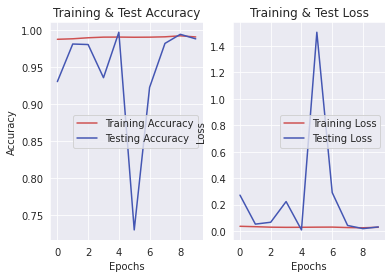

In [41]:
epochs = [i for i in range(10)]
plt.figure(figsize=(30,30))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
ax[0].plot(epochs,train_acc,color="#cf5151",label='Training Accuracy')
ax[0].plot(epochs,val_acc,color="#4456b3",label='Testing Accuracy')
ax[0].set_title('Training & Test Accuracy',fontsize=12)
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[1].plot(epochs,train_loss,color="#cf5151",label='Training Loss')
ax[1].plot(epochs,val_loss,color="#4456b3",label='Testing Loss')
ax[1].set_title('Training & Test Loss',fontsize=12)
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

Let's take a look at the precision, recall and f1 score for each class to evaluate the class-wise model performance on test samples. We will also generate a confusion matrix to visualize the performance and help us identify which characters are the most misclassified and draw insights for further development.

In [42]:
predictions = model.predict_classes(x_test)
for i in range(len(predictions)):
    if(predictions[i]>=9):
        predictions[i] += 1
predictions[:5]   
classes = ["Class "+str(i) for i in range(25) if i!=9]
print(classification_report(y,predictions,target_names=classes))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      0.99      0.99       245
     Class 4       1.00      0.96      0.98       498
     Class 5       1.00      0.99      0.99       247
     Class 6       0.93      1.00      0.97       348
     Class 7       1.00      0.94      0.97       436
     Class 8       0.99      1.00      1.00       288
    Class 10       0.97      1.00      0.99       331
    Class 11       1.00      1.00      1.00       209
    Class 12     

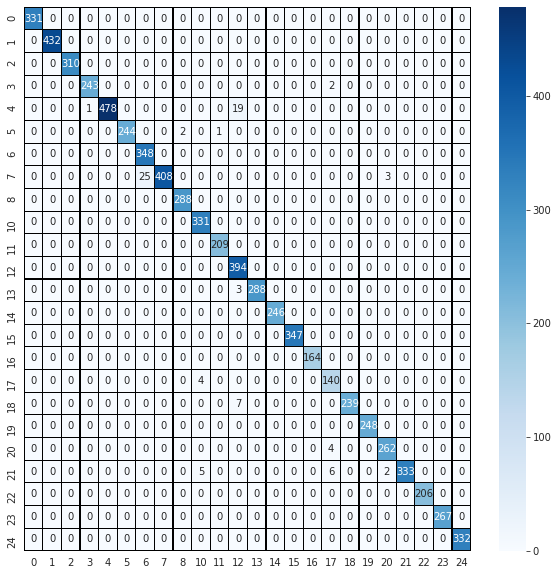

In [44]:
cm = confusion_matrix(y,predictions)
cm = pd.DataFrame(cm,index=[i for i in range(25) if i!=9],columns=[i for i in range(25) if i!=9])
plt.figure(figsize=(10,10))
sns.heatmap(cm,cmap="Blues",linecolor='black',linewidth=0.1,annot=True,fmt='')

It seems that our model is performing quite well for all classes. However, performance on class 17 (letter R) can be worked on. The main reason of letter R not being classified as well as other letters is because of the signs's close resemblance to the signs of letter D, K and U.

###Saving the model as a tflite file for Flutter application

In [45]:
tf.keras.models.save_model(model,"/savedmodels/asl_aplhabet",overwrite=True,include_optimizer=True,save_format='tf',signatures=None,)
asl_model = tf.keras.models.load_model("/savedmodels/asl_aplhabet",custom_objects={'KerasLayer':hub.KerasLayer},compile=True)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /savedmodels/asl_aplhabet/assets


In [48]:
!mkdir "/savedmodels/tflite_models"
#Get the concrete function from the Keras model.
run_model = tf.function(lambda x : asl_model(x))
#Save the concrete function.
concrete_func = run_model.get_concrete_function(
tf.TensorSpec(model.inputs[0].shape,model.inputs[0].dtype))
#Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open("/savedmodels/tflite_models/asl.tflite","wb").write(converted_tflite_model)
#Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open("/savedmodels/tflite_models/asl_quant.tflite","wb").write(tflite_quant_model)
print("TFLite models and their sizes:")
!ls "/savedmodels/tflite_models" -lh

mkdir: cannot create directory ‘/savedmodels/tflite_models’: File exists
TFLite models and their sizes:
total 1.3M
-rw-r--r-- 1 root root 269K Aug 17 12:12 asl_quant.tflite
-rw-r--r-- 1 root root 1.1M Aug 17 12:12 asl.tflite
